In [37]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#modeling
import itertools
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(123)

In [24]:
df = DataReader('AAL', data_source='yahoo', start='2012-01-01', end=datetime.now())

In [25]:
data = df.filter(['Close'])

In [58]:
data.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-30',
               '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03',
               '2021-09-07', '2021-09-08'],
              dtype='datetime64[ns]', name='Date', length=2437, freq=None)

In [26]:
dataset = data.values

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [28]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [29]:
train_data.shape

(2194, 1)

In [30]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets for s = 12 (constant)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [32]:
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 1, 0, 12)
SARIMAX: (0, 0, 0) x (0, 1, 1, 12)
SARIMAX: (0, 0, 0) x (1, 0, 0, 12)
SARIMAX: (0, 0, 0) x (1, 0, 1, 12)
SARIMAX: (0, 0, 0) x (1, 1, 0, 12)
SARIMAX: (0, 0, 0) x (1, 1, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 0, 1) x (0, 1, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)
SARIMAX: (0, 0, 1) x (1, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 1, 0, 12)
SARIMAX: (0, 0, 1) x (1, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 0, 0, 12)
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
SARIMAX: (0, 1, 0) x (1, 0, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 0, 0, 12)
SARIMAX: (0, 1, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x

In [39]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

ans = []
for comb in pdq:
    for combs in seasonal_pdq:
        try:
            mod = SARIMAX(train_data,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)                                    

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =3799.6161839776787
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1102.1790240162202
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-6355.545522815352
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-6323.89698411943
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-6362.086304412698
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-6364.399854466099
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-6325.677422060362
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-6323.735468639443
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =840.8519732342531
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1756.9689233663235
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-8356.87195697485
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-8363.337633258685
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-8369.870073834361
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-8414.85474480704
ARIMA (0,

In [40]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# Find the parameters with minimal AIC value
ans_df.loc[ans_df['aic'].idxmin()]
#output: pdq=(1, 1, 1) and pdqs= (1, 1, 1, 12)


pdq         (1, 1, 0)
pdqs    (0, 0, 0, 12)
aic     -12024.552491
Name: 48, dtype: object

In [42]:
mod = SARIMAX(train_data, order=(1, 1, 0),seasonal_order=(0, 0, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
                                                                
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0691      0.018      3.898      0.000       0.034       0.104
sigma2         0.0002   4.64e-06     52.185      0.000       0.000       0.000


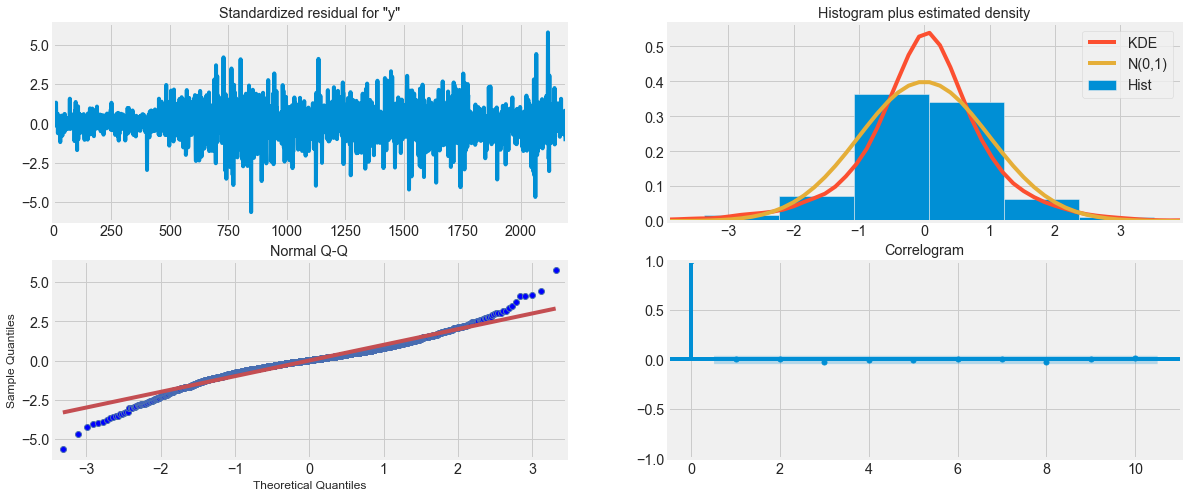

In [43]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [44]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = results.get_prediction(start=pd.to_datetime('2018-09-08'), dynamic=False)
# Get confidence intervals of forecasts
pred_ci = pred.conf_int()

ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
# Get the real and predicted values
y_forecasted = pred.predicted_mean
y_truth = y['2018-06-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))


In [ ]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

In [ ]:
y_truth.head(12)

In [ ]:
pred_ci.head(24)

In [ ]:
forecast = pred_uc.predicted_mean
forecast.head(12)

In [ ]:
#crossval
train_with_ind = train.reset_index()

for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))


y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=valid.index[0], end=valid.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(valid, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')
plt.legend();

fig, ax = plt.subplots()
ax.plot(valid, label='true')
ax.plot(y_hat_test, label='pred')
plt.legend();

np.sqrt(mean_squared_error(valid, y_hat_test))

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = CO2['1990':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [ ]:
# Get dynamic predictions with confidence intervals as above 
#In this case, we only use information from the time series up to a certain point, and after that, 
#forecasts are generated using values from previous forecasted time points.

pred_dynamic = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Extract the predicted and true values of our time series
CO2_forecasted = pred_dynamic.predicted_mean
CO2_truth = CO2['1998-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = CO2['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [ ]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)
pred_conf = prediction.conf_int()

ax = CO2.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [ ]:
forecast = sari_mod.forecast(steps=52)

fig, ax = plt.subplots()
ax.plot(ts_weekly, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Chicago Gun Crime Predictions\n One Year out')

plt.legend();

In [ ]:

sarima_model = SARIMAX(train_data, order=(0, 1, 2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction("1974-01", "1975-12")
predicted_means = p.predicted_mean + df.data.iloc[-36:-1].rolling(12).mean().dropna().values
predicted_intervals = p.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + df.data.iloc[-36:-1].rolling(12).mean().dropna().values
upper_bounds = predicted_intervals['upper station'] + df.data.iloc[-36:-1].rolling(12).mean().dropna().values

sarima_rmse = np.sqrt(np.mean(np.square(test_st.values - p.predicted_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.data.index[100:-24], df.data.values[100:-24]);
ax.plot(test_st.index, test_st.values + df.data.iloc[-36:-1].rolling(12).mean().dropna().values, label='truth');
ax.plot(test_st.index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test_st.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");

In [ ]:

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(y,12)

In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [ ]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2019-06-02',y_to_val)

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [ ]:
final_table = forecast(model,52,y)
final_table.head()